In [1]:
import pandas as pd
import numpy as np

# ==================== 配置参数 ====================
label_col = 'survival_months'
n_bins = 4
eps = 1e-6

In [2]:
# ==================== 第一部分: 处理训练集(HMU) ====================
print("=" * 60)
print("第一部分: 处理训练集 (HMU)")
print("=" * 60)

# 1. 读取HMU数据
train_df = pd.read_csv('/home/stat-jijianxin/PFMs/Survival_code/csv_file/HMU_初次筛选数据整理.csv')

# 2. 数据清洗和重命名
hmu_df = train_df.assign(
    status=lambda x: (x['五年生存状态（0=失访，1=存活，2=死亡）'] == 2).astype(int),
    censorship=lambda x: (x['五年生存状态（0=失访，1=存活，2=死亡）'] != 2).astype(int)
)[['patient', 'OS', 'status', 'censorship', '性别', '年龄', 
   'T分期', 'N分期', 'M分期', '综合分期']].rename(columns={
    'patient': 'case_id',
    'OS': 'survival_months',
    '性别': 'gender',
    '年龄': 'age',
    'T分期': 'T_stage',
    'N分期': 'N_stage',
    'M分期': 'M_stage',
    '综合分期': 'TNM_stage'
})

print(f"\n原始HMU数据形状: {hmu_df.shape}")
print("\n生存状态分布:")
print(pd.crosstab(hmu_df['status'], hmu_df['censorship']))

# 3. 计算分箱边界(只用未删失的患者)
uncensored_df = hmu_df[hmu_df['censorship'] == 0]
print(f"\n未删失患者数: {len(uncensored_df)}")

disc_labels, q_bins = pd.qcut(uncensored_df[label_col], q=n_bins, retbins=True, labels=False)
q_bins[-1] = hmu_df[label_col].max() + eps
q_bins[0] = hmu_df[label_col].min() - eps

print("\n=== 分箱边界 (从HMU训练集计算) ===")
print(f"Bins: {q_bins}")
for i in range(len(q_bins)-1):
    print(f"Bin {i}: [{q_bins[i]:.2f}, {q_bins[i+1]:.2f}) 月")

# 4. 对所有HMU患者进行离散化
disc_labels = pd.cut(hmu_df[label_col], bins=q_bins, labels=False, 
                     right=False, include_lowest=True)
hmu_df.insert(2, 'label', disc_labels.values.astype(int))

# 5. 创建标签字典
label_dict = {}
key_count = 0
for i in range(len(q_bins)-1):
    for c in [0, 1]:  # c=0:事件, c=1:删失
        label_dict.update({(i, c): key_count})
        key_count += 1

print(f"\n=== 标签映射 ===")
for key, value in label_dict.items():
    bin_idx, censor = key
    status = "删失" if censor == 1 else "事件"
    print(f"Bin {bin_idx} + {status} -> Label {value}")

# 6. 添加disc_label和最终label
hmu_df['disc_label'] = hmu_df['label'].astype(int)
hmu_df['label'] = hmu_df.apply(
    lambda row: label_dict[(int(row['disc_label']), int(row['censorship']))], 
    axis=1
)

# 7. 添加slide_id并重排列
hmu_df['slide_id'] = hmu_df['case_id']
cols_order = ['label', 'disc_label', 'case_id', 'slide_id', 'survival_months', 
              'status', 'censorship', 'gender', 'age', 
              'T_stage', 'N_stage', 'M_stage', 'TNM_stage']
hmu_df = hmu_df[cols_order]

# 8. 显示HMU结果
print("\n=== HMU训练集处理结果 ===")
print(hmu_df.head(10))
print(f"\n数据形状: {hmu_df.shape}")
print("\n标签分布:")
print(hmu_df['label'].value_counts().sort_index())
print("\n交叉表: disc_label vs censorship")
print(pd.crosstab(hmu_df['disc_label'], hmu_df['censorship'], margins=True))

# 9. 统计各Bin信息
hmu_bins_info = []
for i in range(len(q_bins)-1):
    bin_data = hmu_df[hmu_df['disc_label'] == i]
    hmu_bins_info.append({
        'bin': i,
        'range': f"[{q_bins[i]:.1f}, {q_bins[i+1]:.1f})",
        'count': len(bin_data),
        'censored': (bin_data['censorship'] == 1).sum(),
        'event': (bin_data['censorship'] == 0).sum(),
        'mean_survival': bin_data['survival_months'].mean()
    })

hmu_bins_df = pd.DataFrame(hmu_bins_info)
print("\n=== HMU各Bin统计 ===")
print(hmu_bins_df)

# 10. 保存HMU结果
hmu_df.to_csv('hmu_survival.csv', index=False)
print("\n✅ HMU训练集已保存到: hmu_survival.csv")

第一部分: 处理训练集 (HMU)

原始HMU数据形状: (2916, 10)

生存状态分布:
censorship     0     1
status                
0              0  1897
1           1019     0

未删失患者数: 1019

=== 分箱边界 (从HMU训练集计算) ===
Bins: [  1.01839585   9.92115637  18.16688568  30.56833114 107.45729404]
Bin 0: [1.02, 9.92) 月
Bin 1: [9.92, 18.17) 月
Bin 2: [18.17, 30.57) 月
Bin 3: [30.57, 107.46) 月

=== 标签映射 ===
Bin 0 + 事件 -> Label 0
Bin 0 + 删失 -> Label 1
Bin 1 + 事件 -> Label 2
Bin 1 + 删失 -> Label 3
Bin 2 + 事件 -> Label 4
Bin 2 + 删失 -> Label 5
Bin 3 + 事件 -> Label 6
Bin 3 + 删失 -> Label 7

=== HMU训练集处理结果 ===
   label  disc_label  case_id  slide_id  survival_months  status  censorship  \
0      7           3  1400865   1400865        83.245729       0           1   
1      7           3  1400793   1400793       103.712221       0           1   
2      7           3  1401410   1401410        65.768725       0           1   
3      7           3  1401025   1401025        75.558476       0           1   
4      7           3  1400716   1400716  

In [3]:
# ==================== 第二部分: 处理测试集(TCGA) ====================
print("\n" + "=" * 60)
print("第二部分: 处理测试集 (TCGA)")
print("=" * 60)

# 1. 读取TCGA数据
tcga_df = pd.read_csv('/home/stat-jijianxin/PFMs/Survival_code/csv_file/tcga_filtered_with_svs_list.csv')

# 2. 数据清洗和重命名
tcga_clean_df = tcga_df.assign(
    status=lambda x: (x['Overall Survival Status'] == '1:DECEASED').astype(int),
    censorship=lambda x: (x['Overall Survival Status'] == '0:LIVING').astype(int)
)[['Patient ID', 'Overall Survival (Months)', 'status', 'censorship', 
   'Sex', 'Diagnosis Age', 
   'AJCC Pathologic T-Stage', 'AJCC Pathologic N-Stage', 
   'AJCC Pathologic M-Stage', 'AJCC Pathologic Stage']].rename(columns={
    'Patient ID': 'case_id',
    'Overall Survival (Months)': 'survival_months',
    'Sex': 'gender',
    'Diagnosis Age': 'age',
    'AJCC Pathologic T-Stage': 'T_stage',
    'AJCC Pathologic N-Stage': 'N_stage',
    'AJCC Pathologic M-Stage': 'M_stage',
    'AJCC Pathologic Stage': 'TNM_stage'
})

print(f"\n原始TCGA数据形状: {tcga_clean_df.shape}")
print("\n生存状态分布:")
print(pd.crosstab(tcga_clean_df['status'], tcga_clean_df['censorship']))

# 3. 使用HMU的bins对TCGA进行离散化
print(f"\n=== 使用HMU训练集的分箱边界 ===")
print(f"Bins: {q_bins}")

disc_labels = pd.cut(tcga_clean_df['survival_months'], 
                     bins=q_bins, 
                     labels=False, 
                     right=False, 
                     include_lowest=True)

tcga_clean_df.insert(2, 'label', disc_labels)

# 4. 检查并处理超出范围的值
out_of_range_mask = tcga_clean_df['label'].isna()
out_of_range = out_of_range_mask.sum()

if out_of_range > 0:
    print(f"\n⚠️ 警告: 有 {out_of_range} 个样本的生存时间超出HMU训练集范围")
    
    out_range_samples = tcga_clean_df[out_of_range_mask][['case_id', 'survival_months']].copy()
    out_range_samples['hmu_min'] = q_bins[0]
    out_range_samples['hmu_max'] = q_bins[-1]
    print("\n超出范围的样本:")
    print(out_range_samples)
    
    # 处理超出范围的值
    mask_too_small = tcga_clean_df['survival_months'] < q_bins[0]
    tcga_clean_df.loc[mask_too_small, 'label'] = 0
    print(f"  - {mask_too_small.sum()} 个样本 < {q_bins[0]:.2f}，归入 Bin 0")
    
    mask_too_large = tcga_clean_df['survival_months'] >= q_bins[-1]
    tcga_clean_df.loc[mask_too_large, 'label'] = len(q_bins) - 2
    print(f"  - {mask_too_large.sum()} 个样本 >= {q_bins[-1]:.2f}，归入 Bin {len(q_bins)-2}")
    
    print("✅ 已将超出范围的样本归入最近的bin")

# 5. 转换为int
tcga_clean_df['disc_label'] = tcga_clean_df['label'].astype(int)

# 6. 验证组合有效性
print(f"\n=== 验证TCGA数据 ===")
print(f"disc_label范围: [{tcga_clean_df['disc_label'].min()}, {tcga_clean_df['disc_label'].max()}]")
print(f"censorship唯一值: {sorted(tcga_clean_df['censorship'].unique())}")

combinations = tcga_clean_df.groupby(['disc_label', 'censorship']).size()
print("\n(disc_label, censorship)组合:")
print(combinations)

# 检查无效组合
invalid_combinations = []
for idx, row in tcga_clean_df.iterrows():
    key = (int(row['disc_label']), int(row['censorship']))
    if key not in label_dict:
        invalid_combinations.append((idx, key, row['case_id']))

if invalid_combinations:
    print(f"\n⚠️ 发现 {len(invalid_combinations)} 个无效组合:")
    for idx, key, case_id in invalid_combinations[:10]:
        print(f"  Index {idx}, case_id {case_id}: {key}")
else:
    print("✅ 所有组合都有效")

# 7. 添加最终label
tcga_clean_df['label'] = tcga_clean_df.apply(
    lambda row: label_dict[(int(row['disc_label']), int(row['censorship']))], 
    axis=1
)

# 8. 添加slide_id并重排列
tcga_clean_df['slide_id'] = tcga_clean_df['case_id']
tcga_clean_df = tcga_clean_df[cols_order]

# 9. 显示TCGA结果
print("\n=== TCGA测试集处理结果 ===")
print(tcga_clean_df.head(10))
print(f"\n数据形状: {tcga_clean_df.shape}")
print("\n标签分布:")
print(tcga_clean_df['label'].value_counts().sort_index())
print("\n交叉表: disc_label vs censorship")
print(pd.crosstab(tcga_clean_df['disc_label'], tcga_clean_df['censorship'], margins=True))

# 10. 统计各Bin信息
tcga_bins_info = []
for i in range(len(q_bins)-1):
    bin_data = tcga_clean_df[tcga_clean_df['disc_label'] == i]
    tcga_bins_info.append({
        'bin': i,
        'range': f"[{q_bins[i]:.1f}, {q_bins[i+1]:.1f})",
        'count': len(bin_data),
        'censored': (bin_data['censorship'] == 1).sum(),
        'event': (bin_data['censorship'] == 0).sum(),
        'mean_survival': bin_data['survival_months'].mean() if len(bin_data) > 0 else 0
    })

tcga_bins_df = pd.DataFrame(tcga_bins_info)
print("\n=== TCGA各Bin统计 ===")
print(tcga_bins_df)

# 11. 保存TCGA结果
tcga_clean_df.to_csv('tcga_survival.csv', index=False)
print("\n✅ TCGA测试集已保存到: tcga_survival.csv")


第二部分: 处理测试集 (TCGA)

原始TCGA数据形状: (342, 10)

生存状态分布:
censorship    0    1
status              
0             0  207
1           135    0

=== 使用HMU训练集的分箱边界 ===
Bins: [  1.01839585   9.92115637  18.16688568  30.56833114 107.45729404]

⚠️ 警告: 有 3 个样本的生存时间超出HMU训练集范围

超出范围的样本:
          case_id  survival_months   hmu_min     hmu_max
264  TCGA-RD-A8MV       122.207622  1.018396  107.457294
267  TCGA-RD-A8N1       115.604468  1.018396  107.457294
268  TCGA-RD-A8N2       116.294350  1.018396  107.457294
  - 0 个样本 < 1.02，归入 Bin 0
  - 3 个样本 >= 107.46，归入 Bin 3
✅ 已将超出范围的样本归入最近的bin

=== 验证TCGA数据 ===
disc_label范围: [0, 3]
censorship唯一值: [0, 1]

(disc_label, censorship)组合:
disc_label  censorship
0           0             53
            1             27
1           0             44
            1             60
2           0             30
            1             58
3           0              8
            1             62
dtype: int64
✅ 所有组合都有效

=== TCGA测试集处理结果 ===
   label  disc_label       case_id 

In [4]:
# ==================== 第三部分: 对比两个数据集 ====================
print("\n" + "=" * 60)
print("第三部分: HMU vs TCGA 对比")
print("=" * 60)

comparison = pd.DataFrame({
    'HMU_count': hmu_df['label'].value_counts().sort_index(),
    'TCGA_count': tcga_clean_df['label'].value_counts().sort_index()
})
comparison = comparison.fillna(0).astype(int)
comparison['HMU_pct'] = (comparison['HMU_count'] / comparison['HMU_count'].sum() * 100).round(2)
comparison['TCGA_pct'] = (comparison['TCGA_count'] / comparison['TCGA_count'].sum() * 100).round(2)

print("\n=== 标签分布对比 ===")
print(comparison)

print("\n=== Bin统计对比 ===")
bins_comparison = pd.merge(hmu_bins_df, tcga_bins_df, on=['bin', 'range'], 
                           suffixes=('_HMU', '_TCGA'))
print(bins_comparison)

print("\n" + "=" * 60)
print("处理完成!")
print("=" * 60)
print(f"✅ HMU训练集: hmu_survival.csv ({hmu_df.shape[0]} 样本)")
print(f"✅ TCGA测试集: tcga_survival.csv ({tcga_clean_df.shape[0]} 样本)")


第三部分: HMU vs TCGA 对比

=== 标签分布对比 ===
   HMU_count  TCGA_count  HMU_pct  TCGA_pct
0        253          53     8.68     15.50
1         20          27     0.69      7.89
2        255          44     8.74     12.87
3         37          60     1.27     17.54
4        256          30     8.78      8.77
5         48          58     1.65     16.96
6        255           8     8.74      2.34
7       1792          62    61.45     18.13

=== Bin统计对比 ===
   bin          range  count_HMU  censored_HMU  event_HMU  mean_survival_HMU  \
0    0     [1.0, 9.9)        273            20        253           6.238177   
1    1    [9.9, 18.2)        292            37        255          13.848712   
2    2   [18.2, 30.6)        304            48        256          24.108795   
3    3  [30.6, 107.5)       2047          1792        255          63.211234   

   count_TCGA  censored_TCGA  event_TCGA  mean_survival_TCGA  
0          80             27          53            5.971583  
1         104         

In [6]:
df_tcga = pd.read_csv('tcga_survival.csv')

In [10]:
df_tcga.iloc[1,]

label                         5
disc_label                    2
case_id            TCGA-B7-5816
slide_id           TCGA-B7-5816
survival_months       26.675427
status                        0
censorship                    1
gender                   Female
age                        51.0
T_stage                     T4a
N_stage                      N0
M_stage                      M0
TNM_stage             Stage IIB
Name: 1, dtype: object

In [ ]:
import os
h5_file = os.listdir('/home/stat-jijianxin/PFMs/TRIDENT/tcga_filtered/20x_512px_0px_overlap/features_conch_v1')

In [1]:
import pandas as pd

In [3]:
df_tcga = pd.read_csv('/home/stat-jijianxin/PFMs/Survival_code/csv_file/tcga_survival_matched.csv')

In [5]:
df_tcga['survival_months']

0      57.982917
1      26.675427
2      34.658344
3      15.932983
4      13.863338
         ...    
337    26.018397
338    16.130092
339    27.529566
340    12.417871
341    17.247043
Name: survival_months, Length: 342, dtype: float64

In [6]:
over_10_years = df_tcga[df_tcga['survival_months'] > 120]

In [11]:
len(over_10_years['slide_id'])

1

In [8]:
df_tcga = df_tcga[df_tcga['survival_months'] <= 120]

In [12]:
df_tcga.to_csv('/home/stat-jijianxin/PFMs/Survival_code/csv_file/tcga_survival_matched.csv', index=None)

In [14]:
df_hmu = pd.read_csv('/home/stat-jijianxin/PFMs/Survival_code/csv_file/hmu_survival.csv')

In [16]:
import os
h5_file = os.listdir('/home/stat-jijianxin/PFMs/HMU_GC_ALL_H5/features_ctranspath/')

In [21]:
df_hmu['gender'].replace('男', 'Male', inplace=True)
df_hmu['gender'].replace('女', 'Female', inplace=True)

In [22]:
df_hmu['gender']

0         Male
1         Male
2         Male
3       Female
4         Male
         ...  
2911    Female
2912    Female
2913    Female
2914      Male
2915      Male
Name: gender, Length: 2916, dtype: object

In [25]:
df_hmu

,label,disc_label,case_id,slide_id,survival_months,status,censorship,gender,age,T_stage,N_stage,M_stage,TNM_stage
0,7,3,1400865,1400865,83.245729,0,1,Male,46,T2,N0,M0,ⅠB
1,7,3,1400793,1400793,103.712221,0,1,Male,32,T2,N3a,M0,ⅢA
2,7,3,1401410,1401410,65.768725,0,1,Male,61,T3,N2,M0,ⅢA
3,7,3,1401025,1401025,75.558476,0,1,Female,57,T4b,N0,M0,ⅢA
4,7,3,1400716,1400716,63.173456,0,1,Male,53,T2,N0,M0,ⅠB
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2911,7,3,1737196,1737196,35.151117,0,1,Female,59,T2,N0,M0,ⅠB
2912,7,3,1736252,1736252,59.132720,0,1,Female,77,T1b,N0,M0,ⅠA
2913,7,3,1807581,1807581,53.942181,0,1,Female,67,T1b,N0,M0,ⅠA
2914,7,3,1814675,1814675,52.529566,0,1,Male,63,T2,N0,M0,ⅠB


In [26]:
df_hmu['slide_id']

0       1400865
1       1400793
2       1401410
3       1401025
4       1400716
         ...   
2911    1737196
2912    1736252
2913    1807581
2914    1814675
2915    1818938
Name: slide_id, Length: 2916, dtype: int64

开始匹配 h5 文件...

匹配结果示例:
   case_id      slide_id
0  1400865  [1400865.h5]
1  1400793  [1400793.h5]
2  1401410  [1401410.h5]
3  1401025  [1401025.h5]
4  1400716  [1400716.h5]
5  1401233  [1401233.h5]
6  1401283  [1401283.h5]
7  1401417  [1401417.h5]
8  1400894  [1400894.h5]
9  1401589  [1401589.h5]

总病例数: 2916
有多个切片的病例数: 119
平均每个病例的切片数: 1.04
扫描 h5 文件目录...
找到 3035 个 h5 文件
找到 2916 个唯一的 case_id

匹配情况统计

切片数分布:
1    2797
2     119
Name: slide_id, dtype: int64

有多个切片的病例数: 119

示例:
     case_id                      slide_id
56   1404071  [1404071-1.h5, 1404071-2.h5]
62   1404601  [1404601-1.h5, 1404601-2.h5]
188  1411768  [1411768-2.h5, 1411768-1.h5]
216  1413117  [1413117-2.h5, 1413117-1.h5]
370  1423065  [1423065-1.h5, 1423065-2.h5]

检查文件是否存在...
✅ 所有文件都存在!

✅ 已保存到: hmu_survival_with_slides.csv


/home/stat-jijianxin/anaconda3/envs/clam/lib/python3.7/site-packages/ipykernel_launcher.py:164: UserWarning: Glyph 27599 (\N{CJK UNIFIED IDEOGRAPH-6BCF}) missing from current font.
/home/stat-jijianxin/anaconda3/envs/clam/lib/python3.7/site-packages/ipykernel_launcher.py:164: UserWarning: Glyph 20010 (\N{CJK UNIFIED IDEOGRAPH-4E2A}) missing from current font.
/home/stat-jijianxin/anaconda3/envs/clam/lib/python3.7/site-packages/ipykernel_launcher.py:164: UserWarning: Glyph 30149 (\N{CJK UNIFIED IDEOGRAPH-75C5}) missing from current font.
/home/stat-jijianxin/anaconda3/envs/clam/lib/python3.7/site-packages/ipykernel_launcher.py:164: UserWarning: Glyph 20363 (\N{CJK UNIFIED IDEOGRAPH-4F8B}) missing from current font.
/home/stat-jijianxin/anaconda3/envs/clam/lib/python3.7/site-packages/ipykernel_launcher.py:164: UserWarning: Glyph 30340 (\N{CJK UNIFIED IDEOGRAPH-7684}) missing from current font.
/home/stat-jijianxin/anaconda3/envs/clam/lib/python3.7/site-packages/ipykernel_launcher.py:164:

可视化图表已保存: slide_distribution.png


/home/stat-jijianxin/anaconda3/envs/clam/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20999 (\N{CJK UNIFIED IDEOGRAPH-5207}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/stat-jijianxin/anaconda3/envs/clam/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 29255 (\N{CJK UNIFIED IDEOGRAPH-7247}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/stat-jijianxin/anaconda3/envs/clam/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/stat-jijianxin/anaconda3/envs/clam/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 37327 (\N{CJK UNIFIED IDEOGRAPH-91CF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/stat-jijianxin/anaconda3/envs/clam/lib/python3.7/site-packages/IPython/core/pylabt

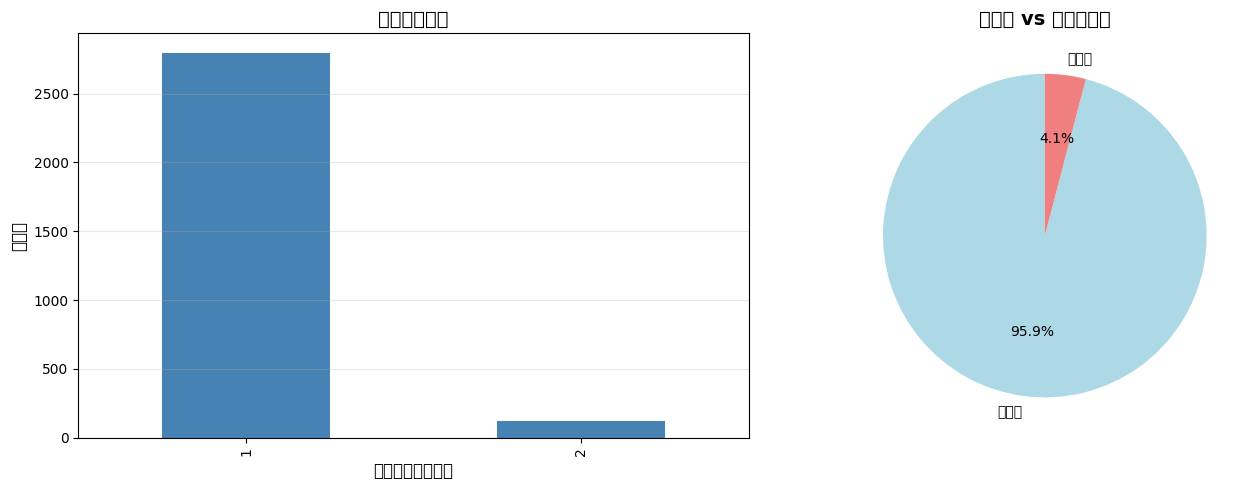

In [27]:
import os
import pandas as pd
from pathlib import Path

# ============================================================
# 配置
# ============================================================
h5_dir = Path('/home/stat-jijianxin/PFMs/HMU_GC_ALL_H5/features_ctranspath')

# ============================================================
# 方法1: 为每个 case_id 匹配所有 h5 文件
# ============================================================
def match_h5_files(case_id, h5_dir):
    """
    为给定的 case_id 匹配所有对应的 h5 文件
    
    例如:
    case_id = 1422220
    返回: ['1422220-1.h5', '1422220-2.h5', '1422220-A.h5']
    """
    case_id_str = str(case_id)
    matched_files = []
    
    # 遍历目录中的所有 h5 文件
    for h5_file in h5_dir.glob('*.h5'):
        filename = h5_file.name
        
        # 检查文件名是否以 case_id 开头
        if filename.startswith(case_id_str):
            # 检查是否完全匹配或有后缀
            # 例如: 1422220.h5, 1422220-1.h5, 1422220-A.h5
            if filename == f"{case_id_str}.h5" or \
               filename.startswith(f"{case_id_str}-"):
                matched_files.append(filename)
    
    return matched_files if matched_files else [f"{case_id_str}.h5"]  # 如果没找到,返回默认


# ============================================================
# 应用到 DataFrame
# ============================================================
print("开始匹配 h5 文件...")

# 为每个 case_id 匹配 h5 文件
df_hmu['slide_id'] = df_hmu['case_id'].apply(
    lambda x: match_h5_files(x, h5_dir)
)

# 查看结果
print("\n匹配结果示例:")
print(df_hmu[['case_id', 'slide_id']].head(10))

# 统计
print(f"\n总病例数: {len(df_hmu)}")
print(f"有多个切片的病例数: {(df_hmu['slide_id'].apply(len) > 1).sum()}")
print(f"平均每个病例的切片数: {df_hmu['slide_id'].apply(len).mean():.2f}")

# ============================================================
# 方法2: 更高效的版本 (预先扫描所有文件)
# ============================================================
def match_all_h5_files_efficient(df, h5_dir):
    """
    更高效的匹配方法:先扫描所有文件,再匹配
    """
    print("扫描 h5 文件目录...")
    
    # 1. 获取所有 h5 文件
    all_h5_files = [f.name for f in h5_dir.glob('*.h5')]
    print(f"找到 {len(all_h5_files)} 个 h5 文件")
    
    # 2. 构建 case_id -> h5文件列表 的映射
    case_to_h5 = {}
    for h5_file in all_h5_files:
        # 提取 case_id (文件名中 '-' 或 '.' 之前的部分)
        if '-' in h5_file:
            case_id = h5_file.split('-')[0]
        else:
            case_id = h5_file.split('.')[0]
        
        # 添加到映射
        if case_id not in case_to_h5:
            case_to_h5[case_id] = []
        case_to_h5[case_id].append(h5_file)
    
    print(f"找到 {len(case_to_h5)} 个唯一的 case_id")
    
    # 3. 匹配
    def get_h5_list(case_id):
        case_id_str = str(case_id)
        return case_to_h5.get(case_id_str, [f"{case_id_str}.h5"])
    
    df['slide_id'] = df['case_id'].apply(get_h5_list)
    
    return df

# 使用高效版本
df_hmu = match_all_h5_files_efficient(df_hmu, h5_dir)

# ============================================================
# 检查匹配情况
# ============================================================
print("\n" + "="*80)
print("匹配情况统计")
print("="*80)

# 统计每个病例的切片数
slide_counts = df_hmu['slide_id'].apply(len)
print(f"\n切片数分布:")
print(slide_counts.value_counts().sort_index())

# 找出有多个切片的病例
multi_slide_cases = df_hmu[slide_counts > 1]
print(f"\n有多个切片的病例数: {len(multi_slide_cases)}")
if len(multi_slide_cases) > 0:
    print("\n示例:")
    print(multi_slide_cases[['case_id', 'slide_id']].head())

# 检查是否有文件不存在
print("\n检查文件是否存在...")
missing_files = []
for idx, row in df_hmu.iterrows():
    for slide_file in row['slide_id']:
        if not (h5_dir / slide_file).exists():
            missing_files.append((row['case_id'], slide_file))

if missing_files:
    print(f"⚠️  发现 {len(missing_files)} 个文件不存在:")
    for case_id, file in missing_files[:10]:  # 只显示前10个
        print(f"  Case {case_id}: {file}")
else:
    print("✅ 所有文件都存在!")

# ============================================================
# 保存结果
# ============================================================
df_hmu.to_csv('hmu_survival_with_slides.csv', index=False)
print(f"\n✅ 已保存到: hmu_survival_with_slides.csv")

# ============================================================
# 可视化切片分布
# ============================================================
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 子图1: 切片数分布
ax1 = axes[0]
slide_counts.value_counts().sort_index().plot(kind='bar', ax=ax1, color='steelblue')
ax1.set_xlabel('每个病例的切片数', fontsize=12)
ax1.set_ylabel('病例数', fontsize=12)
ax1.set_title('切片数量分布', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='y')

# 子图2: 饼图
ax2 = axes[1]
single_vs_multi = pd.Series({
    '单切片': (slide_counts == 1).sum(),
    '多切片': (slide_counts > 1).sum()
})
ax2.pie(single_vs_multi, labels=single_vs_multi.index, autopct='%1.1f%%',
        colors=['lightblue', 'lightcoral'], startangle=90)
ax2.set_title('单切片 vs 多切片病例', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('slide_distribution.png', dpi=300, bbox_inches='tight')
print("可视化图表已保存: slide_distribution.png")
plt.show()
